# Setup

In [1]:
import asyncio
import textwrap
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer

from tasks.text import DESCRIPTIONS, ROUTE, bert_model
from tasks.utils.emissions import clean_emissions_data, get_space_info, tracker
from tasks.utils.evaluation import TextEvaluationRequest

[codecarbon WARNING @ 13:54:33] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:54:33] [setup] RAM Tracking...
[codecarbon INFO @ 13:54:33] [setup] CPU Tracking...
[codecarbon WARNING @ 13:54:33] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon WARNING @ 13:54:33] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 13:54:33] We saw that you have a Apple M3 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 13:54:33] CPU Model on constant consumption mode: Apple M3 Pro
[codecarbon WARNING @ 13:54:33] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:54:33] [setup] GPU Tracking...
[codecarbon INFO @ 13:54:33] No GPU found.
[codecarbon INFO @ 13:54:33] >>> Tracker's metadata:
[codecarbon INFO @ 13:54:33]   Platform system: macOS-15.2-arm64-arm

In [2]:
%config InlineBackend.figure_format='retina'

# Modified code from text.py

In [3]:
MODEL_TYPE = "bert-mini"
# Define the label mapping
LABEL_MAPPING = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7,
}
LABEL_MAPPING_INV = {v: k for k, v in LABEL_MAPPING.items()}

In [4]:
def fetch_test_dataset(request, data_version):
    # This commit
    # https://huggingface.co/datasets/QuotaClimat/frugalaichallenge-text-train/commit/4748e7b548154d188a377a96e104b9b31fcd45b4
    # seemingly changed the way the data is organized and labeled as train & test.
    # data_version = "old" maintains the original code for splitting
    # "new" takes the newly so-called test set
    # Which seems to be the same length, but a different randomization, as the old. :(

    # Load and prepare the dataset
    dataset = load_dataset(request.dataset_name)
    # Convert string labels to integers
    dataset = dataset.map(lambda x: {"label": LABEL_MAPPING[x["label"]]})

    if data_version == "old":
        # Split dataset
        train_test = dataset["train"].train_test_split(
            test_size=request.test_size, seed=request.test_seed
        )
        test_dataset = train_test["test"]
        return test_dataset
    elif data_version == "new":
        test_dataset = dataset["test"]
        return test_dataset
    else:
        raise ValueError(data_version)

In [5]:
async def evaluate_text(
    request: TextEvaluationRequest,
    model_type: str = MODEL_TYPE,
    # This should be an API query parameter, but it looks like the submission repo
    # https://huggingface.co/spaces/frugal-ai-challenge/submission-portal
    # is built in a way to not accept any other endpoints or parameters.
):
    """
    Evaluate text classification for climate disinformation detection.

    Current Model: Random Baseline
    - Makes random predictions from the label space (0-7)
    - Used as a baseline for comparison
    """
    # Get space info
    username, space_url = get_space_info()

    test_dataset = fetch_test_dataset(request, "new")

    # Start tracking emissions
    tracker.start()
    tracker.start_task("inference")

    # --------------------------------------------------------------------------------------------
    # YOUR MODEL INFERENCE CODE HERE
    # Update the code below to replace the random baseline by your model inference within the inference pass where the energy consumption and emissions are tracked.
    # --------------------------------------------------------------------------------------------

    true_labels = test_dataset["label"]
    if model_type == "baseline":
        predictions = baseline_model(len(true_labels))
    elif model_type[:5] == "bert-":
        predictions = bert_model(test_dataset, model_type)
    else:
        raise ValueError(model_type)

    # --------------------------------------------------------------------------------------------
    # YOUR MODEL INFERENCE STOPS HERE
    # --------------------------------------------------------------------------------------------

    # Stop tracking emissions
    emissions_data = tracker.stop_task()

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)

    # Prepare results dictionary
    results = {
        "username": username,
        "space_url": space_url,
        "submission_timestamp": datetime.now().isoformat(),
        "model_description": DESCRIPTIONS[model_type],
        "accuracy": float(accuracy),
        "energy_consumed_wh": emissions_data.energy_consumed * 1000,
        "emissions_gco2eq": emissions_data.emissions * 1000,
        "emissions_data": clean_emissions_data(emissions_data),
        "api_route": ROUTE,
        "dataset_config": {
            "dataset_name": request.dataset_name,
            "test_size": request.test_size,
            "test_seed": request.test_seed,
        },
    }

    return results, predictions

In [6]:
results, predictions = await evaluate_text(request=TextEvaluationRequest())

Starting my code block.
Loading from model_repo: Nonnormalizable/frugal-ai-text-bert-mini
Using device: mps
Starting model run.


[codecarbon INFO @ 13:54:38] Energy consumed for RAM : 0.000005 kWh. RAM Power : 6.75 W
[codecarbon INFO @ 13:54:38] Delta energy consumed for CPU with constant : 0.000029 kWh, power : 42.5 W
[codecarbon INFO @ 13:54:38] Energy consumed for All CPU : 0.000029 kWh
[codecarbon INFO @ 13:54:38] 0.000033 kWh of electricity used since the beginning.


End of model run.
End of my code block.


With CPU on my laptop:\
`[codecarbon INFO @ 13:47:40] 0.000128 kWh of electricity used since the beginning.`

With MPS on my laptop:\
`[codecarbon INFO @ 13:54:38] 0.000033 kWh of electricity used since the beginning.`

# Analysis

## Construct dataset

In [7]:
test_dataset = fetch_test_dataset(TextEvaluationRequest(), "new")
tokenizer = AutoTokenizer.from_pretrained(
    f"Nonnormalizable/frugal-ai-text-{MODEL_TYPE}"
)
tokens = tokenizer(test_dataset["quote"])
token_lengths = [len(t) for t in tokens["input_ids"]]

In [8]:
results["accuracy"]

0.8580803937653815

In [9]:
len(predictions)

1219

In [10]:
len(predictions) * results["accuracy"]

1046.0

In [11]:
len(predictions) / 0.20

6095.0

In [12]:
analysis_df = pd.DataFrame()
for f in test_dataset.features:
    c = pd.Series(test_dataset[f])
    analysis_df[f] = c

analysis_df["predicted_label"] = pd.Series(predictions).astype(int)

analysis_df = analysis_df.rename(
    columns={"__index_level_0__": "index_0", "label": "true_label"}
).set_index("index_0", verify_integrity=True)
analysis_df["quote_length_token"] = token_lengths
analysis_df = analysis_df.sort_index()
analysis_df["is_correct"] = (
    analysis_df.true_label == analysis_df.predicted_label
).astype(int)
analysis_df = analysis_df.assign(is_wrong=1 - analysis_df.is_correct)

analysis_df["quote_length_char"] = analysis_df["quote"].str.len()
analysis_df["quote_length_word"] = analysis_df["quote"].str.split().apply(len)

In [13]:
analysis_df.sample(5)

quote  true_label  \
index_0                                                                  
5011     It’s very costly to operate here in America co...           0   
3523     It would be necessary to use ambiguous and mis...           0   
3641     Unfortunately, Canada doesn’t have a Nigel Law...           4   
746      This is recognised by the major carbon dioxide...           0   
2273     Climate change is a genuine problem that will ...           0   

         source                                                url language  \
index_0                                                                       
5011     Desmog                https://www.desmog.com/harold-hamm/       en   
3523     Desmog             https://www.desmog.com/george-pearson/       en   
3641     Desmog  https://www.desmog.com/canadians-for-affordabl...       en   
746       FLICC  https://huggingface.co/datasets/fzanartu/FLICC...       en   
2273     Desmog              https://www.desmog.com/bjorn-lomborg/       en   

        subsource    id  predicted_label  quote_length_token  is_correct  \
index_0                                                                    
5011         None  None                0                  68           1   
3523         None  None                0                  47           1   
3641         None  None                4                 122           1   
746      jintrain  None                0                  35           1   
2273         None  None                3                 102           0   

         is_wrong  quote_length_char  quote_length_word  
index_0                                                  
5011            0                311                 55  
3523            0                238                 40  
3641            0                572                 98  
746             0                140                 26  
2273            1                510                 79

In [14]:
analysis_df.describe()

true_label  predicted_label  quote_length_token   is_correct  \
count  1219.000000      1219.000000         1219.000000  1219.000000   
mean      2.828548         2.908942           60.122231     0.858080   
std       2.322724         2.278062           46.903184     0.349111   
min       0.000000         0.000000            7.000000     0.000000   
25%       0.000000         1.000000           30.000000     1.000000   
50%       3.000000         3.000000           48.000000     1.000000   
75%       5.000000         5.000000           77.000000     1.000000   
max       7.000000         7.000000          561.000000     1.000000   

          is_wrong  quote_length_char  quote_length_word  
count  1219.000000        1219.000000        1219.000000  
mean      0.141920         279.809680          46.735029  
std       0.349111         226.966534          37.764322  
min       0.000000          24.000000           4.000000  
25%       0.000000         136.000000          23.000000  
50%       0.000000         222.000000          37.000000  
75%       0.000000         360.500000          60.000000  
max       1.000000        2643.000000         454.000000

In [15]:
analysis_df.isna().mean()

quote                 0.000000
true_label            0.000000
source                0.000000
url                   0.000000
language              0.000000
subsource             0.675144
id                    1.000000
predicted_label       0.000000
quote_length_token    0.000000
is_correct            0.000000
is_wrong              0.000000
quote_length_char     0.000000
quote_length_word     0.000000
dtype: float64

In [16]:
analysis_df[["quote_length_char", "quote_length_word", "quote_length_token"]].corr()

quote_length_char  quote_length_word  quote_length_token
quote_length_char            1.000000           0.992111            0.988758
quote_length_word            0.992111           1.000000            0.993291
quote_length_token           0.988758           0.993291            1.000000

## Error distribution across classes

In [17]:
heatmap_df = analysis_df.pivot_table(
    columns="true_label", index="predicted_label", aggfunc="count", values="quote"
).fillna(0)
heatmap_df

true_label           0      1      2     3      4      5      6     7
predicted_label                                                      
0                252.0    4.0    1.0   2.0    6.0    0.0    0.0   1.0
1                  3.0  143.0    3.0   7.0    1.0    6.0    3.0   0.0
2                  5.0    4.0  125.0   5.0    0.0   15.0    1.0   3.0
3                  8.0    0.0    3.0  80.0    3.0    0.0    0.0   0.0
4                  9.0    0.0    1.0   1.0  136.0    0.0    3.0  10.0
5                 13.0    1.0    4.0   1.0    7.0  136.0    6.0   0.0
6                 16.0    2.0    0.0   1.0    2.0    3.0  123.0   0.0
7                  1.0    0.0    0.0   0.0    5.0    0.0    3.0  51.0

<Axes: xlabel='true_label', ylabel='predicted_label'>

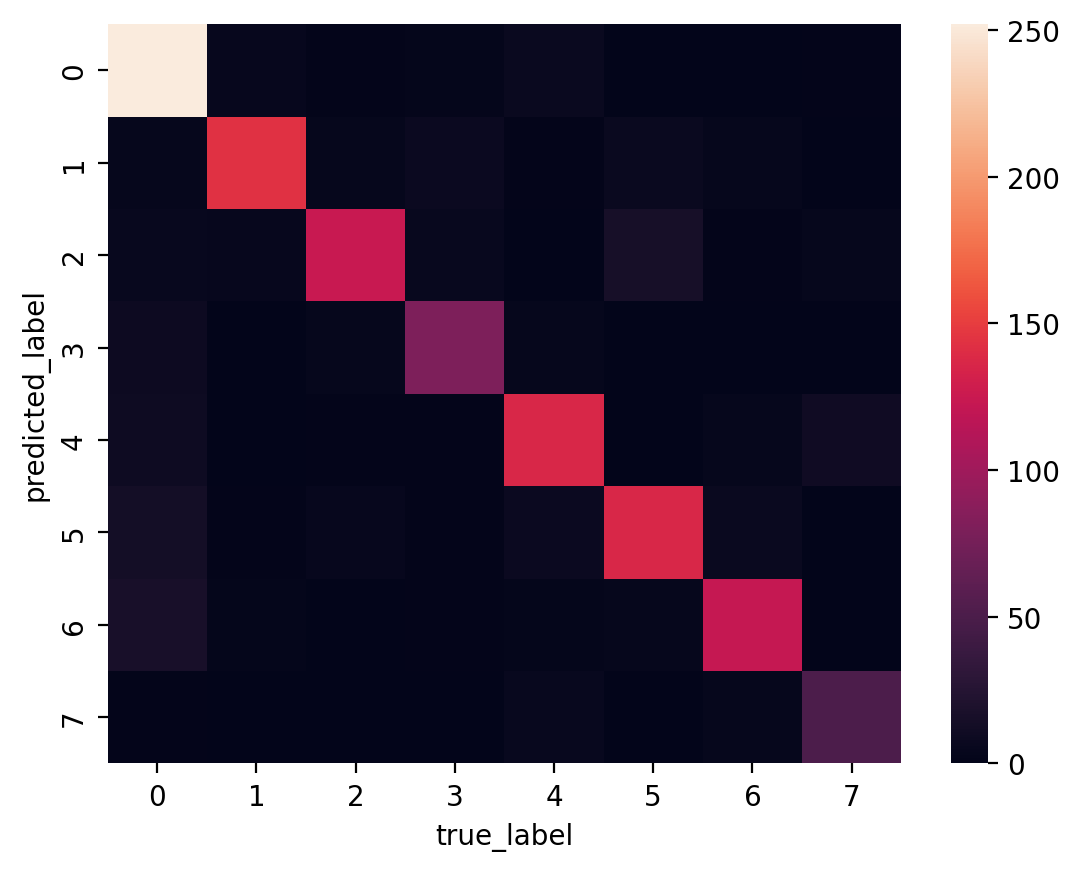

In [18]:
sns.heatmap(heatmap_df)

<Axes: xlabel='true_label', ylabel='predicted_label'>

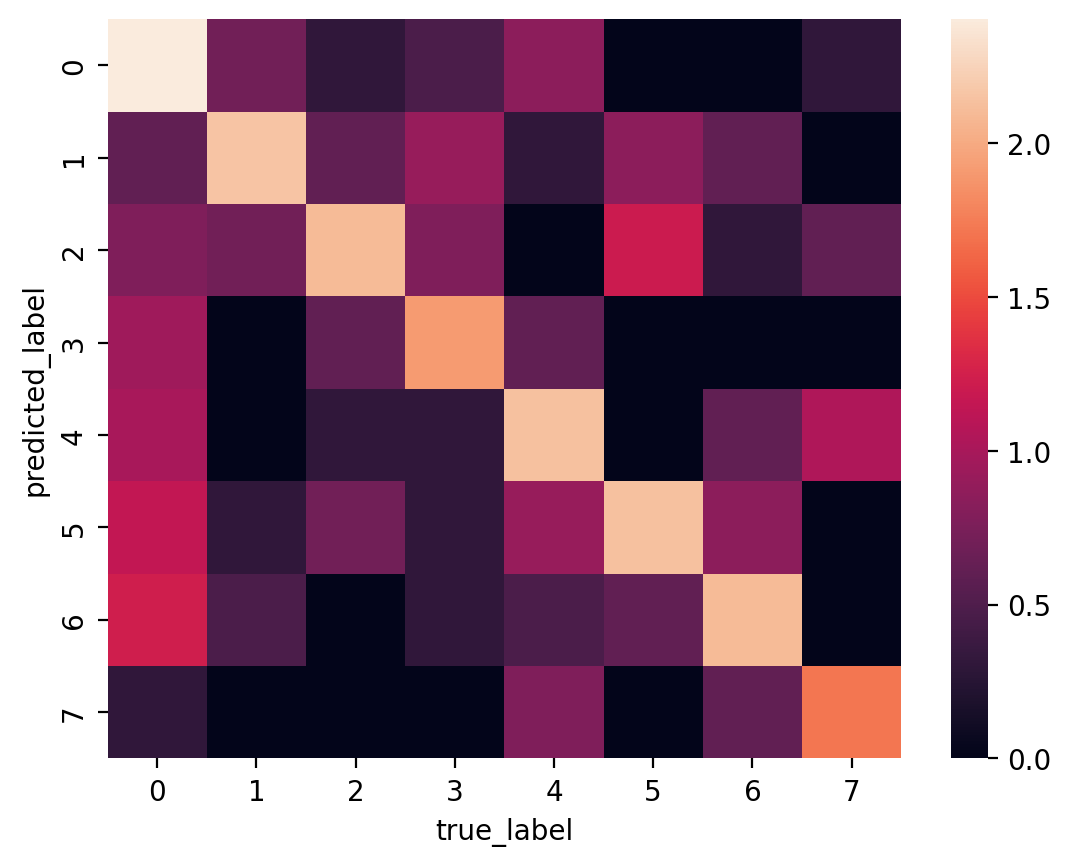

In [19]:
sns.heatmap(np.log10(heatmap_df + 1))

In [20]:
analysis_df.groupby("true_label").agg({"is_wrong": "mean"}).sort_values(
    "is_wrong", ascending=False
)

is_wrong
true_label          
7           0.215385
0           0.179153
3           0.175258
4           0.150000
5           0.150000
6           0.115108
2           0.087591
1           0.071429

In [21]:
analysis_df.groupby("true_label").agg({"is_wrong": "sum"}).sort_values(
    "is_wrong", ascending=False
)

is_wrong
true_label          
0                 55
4                 24
5                 24
3                 17
6                 16
7                 14
2                 12
1                 11

## Quote length

In [22]:
analysis_df.groupby("is_correct")[
    ["quote_length_char", "quote_length_word", "quote_length_token"]
].describe().transpose().round(1)

is_correct                     0       1
quote_length_char  count   173.0  1046.0
                   mean    298.0   276.8
                   std     262.0   220.6
                   min      34.0    24.0
                   25%     129.0   136.0
                   50%     221.0   224.0
                   75%     368.0   360.0
                   max    1546.0  2643.0
quote_length_word  count   173.0  1046.0
                   mean     49.6    46.3
                   std      42.7    36.9
                   min       7.0     4.0
                   25%      22.0    23.0
                   50%      37.0    37.0
                   75%      60.0    59.0
                   max     273.0   454.0
quote_length_token count   173.0  1046.0
                   mean     63.2    59.6
                   std      51.8    46.1
                   min      11.0     7.0
                   25%      30.0    31.0
                   50%      49.0    48.0
                   75%      77.0    77.0
                   max     337.0   561.0

In [23]:
analysis_df.groupby(["source"])[
    ["quote_length_char", "quote_length_word", "quote_length_token"]
].describe().transpose().round(1)

source                    Desmog  FLICC
quote_length_char  count   823.0  396.0
                   mean    321.9  192.3
                   std     251.6  125.5
                   min      44.0   24.0
                   25%     155.0  106.0
                   50%     259.0  159.0
                   75%     401.5  248.5
                   max    2643.0  878.0
quote_length_word  count   823.0  396.0
                   mean     53.7   32.2
                   std      41.9   20.6
                   min      11.0    4.0
                   25%      26.5   18.0
                   50%      43.0   27.0
                   75%      67.0   42.0
                   max     454.0  140.0
quote_length_token count   823.0  396.0
                   mean     68.7   42.3
                   std      52.1   26.0
                   min      14.0    7.0
                   25%      35.0   25.0
                   50%      56.0   36.0
                   75%      85.0   54.0
                   max     561.0  176.0

In [24]:
analysis_df.groupby(["true_label"])[
    ["quote_length_char", "quote_length_word", "quote_length_token"]
].mean().transpose().round(1)

true_label              0      1      2      3      4      5      6      7
quote_length_char   267.5  195.4  285.9  258.0  342.8  308.9  278.3  334.4
quote_length_word    44.6   34.0   47.9   43.3   56.4   51.6   45.9   55.8
quote_length_token   57.8   44.0   60.9   55.9   71.6   66.4   60.1   70.6

/var/folders/6x/4bcqvs9d4cvcnt_qj6jpmj300000gn/T/ipykernel_78254/1952994841.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


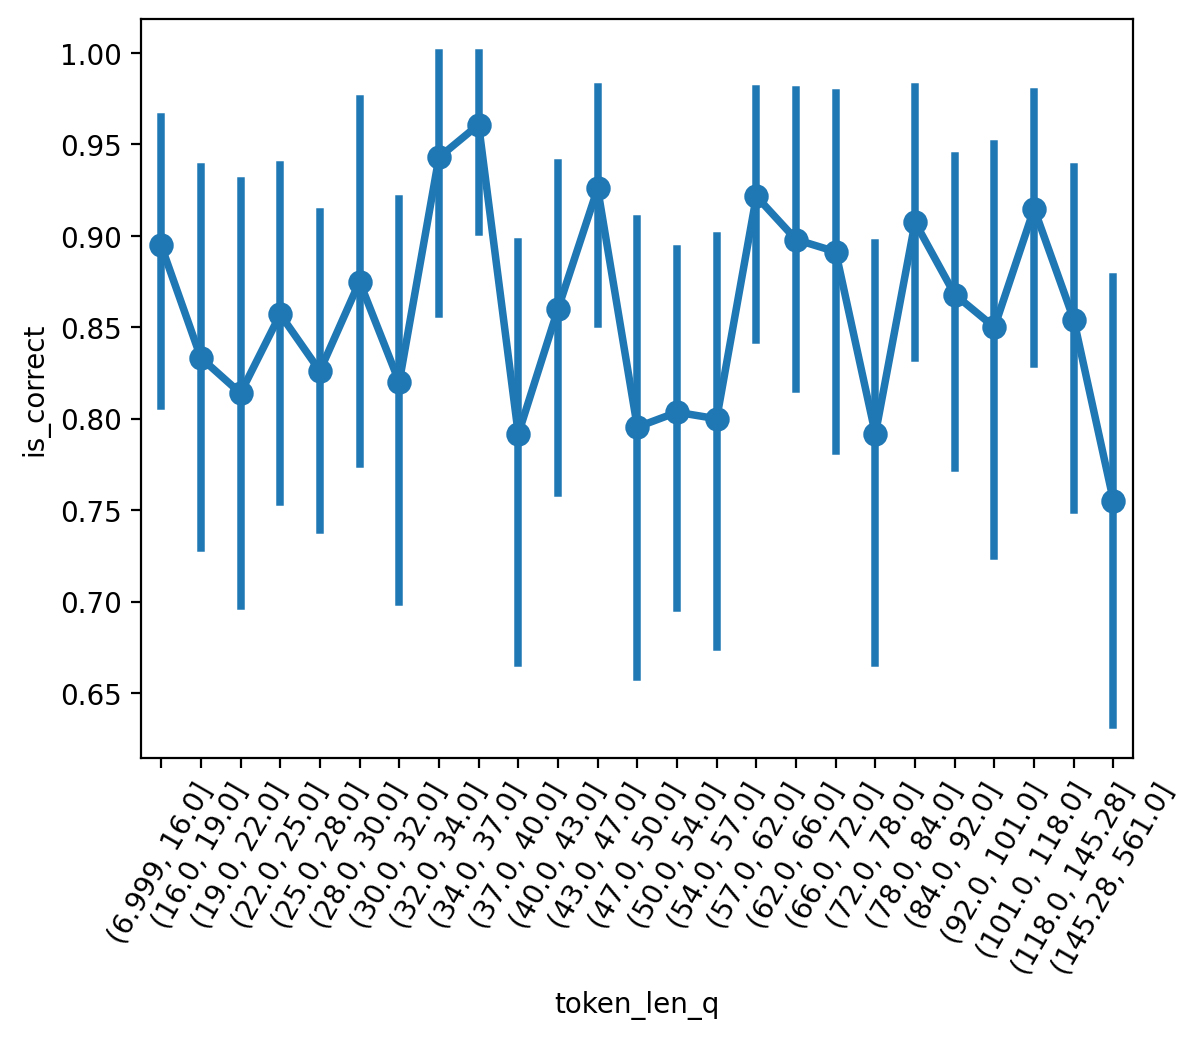

In [25]:
analysis_df["token_len_q"] = pd.qcut(analysis_df["quote_length_token"], q=25)
ax = sns.pointplot(analysis_df, x="token_len_q", y="is_correct")
labels = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)

In [26]:
analysis_df["token_len_q_manual"] = (analysis_df["quote_length_token"] > 145).astype(
    int
)
analysis_df.groupby("token_len_q_manual").agg({"is_correct": "mean", "quote": "count"})

is_correct  quote
token_len_q_manual                   
0                     0.862393   1170
1                     0.755102     49

In [27]:
analysis_df["token_len_q_manual"] = (analysis_df["quote_length_token"] > 256).astype(
    int
)
analysis_df.groupby("token_len_q_manual").agg({"is_correct": "mean", "quote": "count"})

is_correct  quote
token_len_q_manual                   
0                     0.858091   1205
1                     0.857143     14

## Source, etc.

In [28]:
analysis_df.groupby(["source"], dropna=False).agg(
    {"is_correct": "mean", "quote": "count"}
).sort_values("quote", ascending=False)

is_correct  quote
source                   
Desmog    0.851762    823
FLICC     0.871212    396

In [29]:
analysis_df.groupby(["source", "subsource"], dropna=False).agg(
    {"is_correct": "mean", "quote": "count"}
).sort_values("quote", ascending=False)

is_correct  quote
source subsource                       
Desmog NaN              0.851762    823
FLICC  CARDS            0.900621    161
       hamburg_test3    0.829545     88
       jintrain         0.947368     38
       hamburg_test2    0.766667     30
       Alhindi_train    0.875000     24
       hamburg_test1    0.833333     24
       jintest          0.818182     11
       Alhindi_dev      0.800000     10
       jindev           1.000000      9
       Alhindi_test     1.000000      1

In [30]:
analysis_df.groupby(["language"], dropna=False).agg(
    {"is_correct": "mean", "quote": "count"}
).sort_values("quote", ascending=False)

is_correct  quote
language                   
en           0.85808   1219

In [31]:
analysis_df.groupby(["url"], dropna=False).agg(
    {"is_correct": "mean", "quote": "count"}
).sort_values("quote", ascending=False).head(10)

is_correct  quote
url                                                                  
https://huggingface.co/datasets/fzanartu/FLICCd...    0.871212    396
https://www.desmog.com/manning-foundation-for-d...    0.800000     10
https://www.desmog.com/marlo-lewis-jr/                0.700000     10
https://www.desmog.com/lee-raymond/                   0.600000     10
https://www.desmog.com/michael-shellenberger/         0.555556      9
https://www.desmog.com/bjorn-lomborg/                 0.625000      8
https://www.desmog.com/fred-palmer/                   0.714286      7
https://www.desmog.com/naomi-seibt/                   0.833333      6
https://www.desmog.com/myron-ebell/                   1.000000      6
https://www.desmog.com/william-briggs/                0.833333      6

## Look at examples

In [32]:
def print_example(i, row, errors_categorized=None):
    print(
        i,
        row.source,
        row.subsource,
        f"true={LABEL_MAPPING_INV[row.true_label]}",
        f"predict={LABEL_MAPPING_INV[row.predicted_label]}",
    )
    print(textwrap.fill(row.quote, width=80))
    if errors_categorized is not None:
        print(f"My categorization: {errors_categorized[i]}")
    print()

In [33]:
for i, row in (
    analysis_df.query("is_correct == 1").sample(20, random_state=1).iterrows()
):
    print_example(i, row)

198 FLICC CARDS true=5_science_unreliable predict=5_science_unreliable
The inference is that climate model predictions should be used to drive global
energy policy. This is the simple linear model of scientism, that has been
resoundingly debunked particularly for a complex problem like climate change.

5057 Desmog None true=0_not_relevant predict=0_not_relevant
So you don’t think we’re headed to two degrees on our current path?

3372 Desmog None true=6_proponents_biased predict=6_proponents_biased
Schemes and fibs by environmental extremists like Al Gore, Tom Steyer, and
leaders at Google are killing jobs, increasing the price of energy, devouring
tax dollars, and threatening America’s energy independence — all in an effort to
make a quick buck.

681 FLICC CARDS true=5_science_unreliable predict=5_science_unreliable
First up, a common misconception in the climate debate is that radiation from a
cold body (e.g. the -18C atmosphere) can warm a hot body (e.g. the +15C Earth
surface) just 

In [34]:
errors_categorized = {}
ERROR_TBD = "TBD"
ERROR_BOTH = "Both true and predicted labels are reasonable."
ERROR_THIRD = "Some other third label is correct."
ERROR_ACTUALLY = "The model label is correct, the true label is wrong."
ERROR_SIMPLE = "The model is just wrong."

errors_categorized[3340] = ERROR_BOTH
errors_categorized[3836] = ERROR_THIRD
errors_categorized[555] = ERROR_SIMPLE
errors_categorized[2477] = ERROR_SIMPLE
errors_categorized[1912] = ERROR_SIMPLE
errors_categorized[4792] = ERROR_SIMPLE
errors_categorized[4356] = ERROR_ACTUALLY
errors_categorized[354] = ERROR_ACTUALLY
errors_categorized[3653] = ERROR_BOTH
errors_categorized[3807] = ERROR_BOTH
errors_categorized[233] = ERROR_SIMPLE
errors_categorized[84] = ERROR_THIRD
errors_categorized[3652] = ERROR_SIMPLE
errors_categorized[1483] = ERROR_SIMPLE
errors_categorized[3614] = ERROR_BOTH
errors_categorized[3800] = ERROR_SIMPLE
errors_categorized[5317] = ERROR_BOTH
errors_categorized[1192] = ERROR_ACTUALLY
errors_categorized[4313] = ERROR_SIMPLE
errors_categorized[1172] = ERROR_ACTUALLY

In [35]:
print(LABEL_MAPPING_INV)

{0: '0_not_relevant', 1: '1_not_happening', 2: '2_not_human', 3: '3_not_bad', 4: '4_solutions_harmful_unnecessary', 5: '5_science_unreliable', 6: '6_proponents_biased', 7: '7_fossil_fuels_needed'}


In [36]:
for i, row in (
    analysis_df.query("is_correct == 0").sample(20, random_state=1).iterrows()
):
    if i not in errors_categorized:
        errors_categorized[i] = ERROR_TBD
    print_example(i, row, errors_categorized)

3340 Desmog None true=5_science_unreliable predict=2_not_human
Climate is becoming increasingly warmer we hear almost every day. This is what
has become known as Global Warming. The driving idea is that there is a linear
relationship between CO2 increase in the atmosphere and global temperature. The
fact, however, is that temperature has constantly gone up and down. From 1850 to
1970, we see an almost linear relationship with Solar variability; not CO2. For
the last 30 years, our data sets are so contaminated by personal interpretations
and personal choices that it is almost impossible to sort up the mess in
reliable and unreliable data,
My categorization: Both true and predicted labels are reasonable.

3836 Desmog None true=5_science_unreliable predict=2_not_human
I think there is man made climate change, I don’t think it’s as pressing as some
people have suggested.
My categorization: Some other third label is correct.

555 FLICC hamburg_test2 true=2_not_human predict=1_not_happening


In [37]:
errors = pd.DataFrame(pd.Series(errors_categorized, name="error_type"))
errors

error_type
3340     Both true and predicted labels are reasonable.
3836                 Some other third label is correct.
555                            The model is just wrong.
2477                           The model is just wrong.
1912                           The model is just wrong.
4792                           The model is just wrong.
4356  The model label is correct, the true label is ...
354   The model label is correct, the true label is ...
3653     Both true and predicted labels are reasonable.
3807     Both true and predicted labels are reasonable.
233                            The model is just wrong.
84                   Some other third label is correct.
3652                           The model is just wrong.
1483                           The model is just wrong.
3614     Both true and predicted labels are reasonable.
3800                           The model is just wrong.
5317     Both true and predicted labels are reasonable.
1192  The model label is correct, the true label is ...
4313                           The model is just wrong.
1172  The model label is correct, the true label is ...

In [38]:
errors.value_counts() / errors.shape[0]

error_type                                          
The model is just wrong.                                0.45
Both true and predicted labels are reasonable.          0.25
The model label is correct, the true label is wrong.    0.20
Some other third label is correct.                      0.10
Name: count, dtype: float64

In [39]:
analysis_df["error_type"] = errors["error_type"]

In [40]:
analysis_df["error_type"].value_counts(dropna=False)

error_type
NaN                                                     1199
The model is just wrong.                                   9
Both true and predicted labels are reasonable.             5
The model label is correct, the true label is wrong.       4
Some other third label is correct.                         2
Name: count, dtype: int64

In [41]:
analysis_df.query("is_correct == 0").groupby(
    ["source", "error_type"], dropna=False
).agg({"quote": "count"})

quote
source error_type                                               
Desmog Both true and predicted labels are reasonable.          5
       Some other third label is correct.                      1
       The model is just wrong.                                6
       The model label is correct, the true label is w...      1
       NaN                                                   109
FLICC  Some other third label is correct.                      1
       The model is just wrong.                                3
       The model label is correct, the true label is w...      3
       NaN                                                    44